# Subreddit Classification - Modeling

## Classification Modeling using cleaned title text, raw title character count, and raw title word count

### Importing necessary libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
import time
import warnings
import regex as re

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
warnings.filterwarnings('ignore')
np.random.seed(824)
from bs4 import BeautifulSoup 
from nltk.corpus import stopwords
from sklearn.naive_bayes import MultinomialNB

## Grab cleaned dataframe

In [2]:
df = pd.read_csv('../datasets/preprocessed_data.csv')

In [3]:
df.drop(columns = 'Unnamed: 0', inplace = True)

In [4]:
df.head(2)

,title,selftext,subreddit,title_char_count,title_word_count,selftext_char_count,selftext_word_count,clean_title,clean_selftext,clean_title_word_count,clean_selftext_word_count,all_content,clean_content_word_count
0,7 rules for surviving The Crack,"“We have to rewrite it, there is no other poss...",1,31,6,6003,1138,rules surviving crack,rewrite possibility rewrite understand rewriti...,3,451,rules surviving crack rewrite possibility rewr...,1138
1,I was followed home one night and got a tape t...,It was a warm night in a town just outside of ...,1,61,13,2471,505,followed home night got tape morning,warm night town just outside london ontario co...,6,193,followed home night got tape morning warm nigh...,505


In [5]:
df.isnull().sum()

title                          7
selftext                       6
subreddit                      0
title_char_count               0
title_word_count               0
selftext_char_count            0
selftext_word_count            0
clean_title                  274
clean_selftext                42
clean_title_word_count         0
clean_selftext_word_count      0
all_content                    0
clean_content_word_count       0
dtype: int64

In [6]:
df = df.dropna()

In [7]:
df.isnull().sum()

title                        0
selftext                     0
subreddit                    0
title_char_count             0
title_word_count             0
selftext_char_count          0
selftext_word_count          0
clean_title                  0
clean_selftext               0
clean_title_word_count       0
clean_selftext_word_count    0
all_content                  0
clean_content_word_count     0
dtype: int64

## Our data is finally ready for modeling.....

## Let's work with our title data

In [8]:
# we will use these transformers in our pipeline later on
# create functions to return just the columns that you care about
get_text_data = FunctionTransformer(lambda x: x['clean_title'], validate = False)
get_numeric_data = FunctionTransformer(lambda x: x[['title_char_count','title_word_count']], validate = False)

In [9]:
features = ['clean_title',
            'title_char_count', 
            'title_word_count'
           ]
X = df[features]
y = df['subreddit']

## Determine baseline accuracy

In [10]:
print(f'Baseline Model Accuracy = {y.value_counts(normalize = True)[1] * 100}%')

Baseline Model Accuracy = 50.134579249403274%


## Train/Test Split the data

In [11]:
# Create train_test_split.
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                   random_state = 42,
                                                   stratify = y)

## Logistic Regression using Count Vectorizer - Pipeline and GridSearch

In [12]:
cvec_pipe = Pipeline([
    ('features', FeatureUnion([
            ('numeric_features', Pipeline([ #this transformer grabs all numeric data (sentiment and counts)
                ('selector', get_numeric_data), 
                ('ss', StandardScaler())
            ])),
            ('text_features', Pipeline([# this transformer dummifies each word into corpus
                ('selector', get_text_data),
                ('cvec', CountVectorizer())
            ]))
    ])),
    ('logreg', LogisticRegression())
])

cvec_params = {    
    'features__text_features__cvec__stop_words' : [None],
    'features__text_features__cvec__min_df' : [1],
    'features__text_features__cvec__max_df' : [0.25],
    'features__text_features__cvec__ngram_range' : [(1,3)],
    'logreg__penalty' : ['l2']
}

cvec_gs = GridSearchCV(cvec_pipe, 
                  cvec_params, 
                  cv=5)

cvec_gs.fit(X_train, y_train)
cvec_gs.best_score_

0.7210866885195988

In [13]:
#Accuracy scores
print ('Best CountVectorizer Regression Model:') 
print (cvec_gs.best_params_)
print (f'Training Accuracy Score: {round(cvec_gs.score(X_train, y_train) * 100, 2)}%.')
print (f'Testing Accuracy Score: {round(cvec_gs.score(X_test, y_test) * 100, 2)}%.')

Best CountVectorizer Regression Model:
{'features__text_features__cvec__max_df': 0.25, 'features__text_features__cvec__min_df': 1, 'features__text_features__cvec__ngram_range': (1, 3), 'features__text_features__cvec__stop_words': None, 'logreg__penalty': 'l2'}
Training Accuracy Score: 93.63%.
Testing Accuracy Score: 72.6%.


### Evaluate our Model

In [14]:
def nice_conmat(y_test, preds, classes):

    conmat = confusion_matrix(y_test, preds)
    print(f'Accuracy Score: {accuracy_score(y_test, preds)}')
    return pd.DataFrame(conmat, columns=['Predicted ' +class_ for class_ in classes], \
                index=['Actual '+ class_ for class_ in classes])

In [15]:
# build a function to print out a nice confusion matrix
preds = cvec_gs.best_estimator_.predict(X_test)

confuse = nice_conmat(y_test, preds, ['scarystories', 'nosleep'])
confuse

Accuracy Score: 0.72598009343896


,Predicted scarystories,Predicted nosleep
Actual scarystories,1805,650
Actual nosleep,699,1769


In [16]:
confuse.to_csv('../datasets/title_confusion.csv')

In [17]:
# Calculate classification metrics
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

accuracy = (tp + tn) / (tp + fn + fp + tn) * 100
misclassification = (100 - accuracy)
sensitivity = tp / (tp + fn) * 100
specificity = tn / (tn + fp) * 100
precision = tp / (tp + fp) * 100

print(f'Accuracy: {round(accuracy, 2)}%')
print(f'Misclassification rate: {round(misclassification, 2)}%')
print(f'Recall / Sensitivity: {round(sensitivity, 2)}%')
print(f'Specificity: {round(specificity, 2)}%')
print(f'Precision: {round(precision, 2)}%')

Accuracy: 72.6%
Misclassification rate: 27.4%
Recall / Sensitivity: 71.68%
Specificity: 73.52%
Precision: 73.13%


In [18]:
#coefficients
coefficients = cvec_gs.best_estimator_.named_steps['logreg'].coef_[0]

In [19]:
len(coefficients)

50336

In [20]:
features = cvec_gs.best_estimator_.named_steps['features'].transformer_list[1][1].named_steps['cvec'].get_feature_names()

In [21]:
print(f'There are {len(coefficients)} coefficients.')
print(f'There are {len(features)} features.')

There are 50336 coefficients.
There are 50334 features.


In [22]:
features = ['title_char_count', 'title_word_count'] +\
cvec_gs.best_estimator_.named_steps['features'].transformer_list[1][1].named_steps['cvec'].get_feature_names()


coefficients = cvec_gs.best_estimator_.named_steps['logreg'].coef_[0]

In [23]:
coef_df = pd.DataFrame({'features': features, 
              'coef' : coefficients,
              'exp_coef': [np.exp(coef) for coef in coefficients] #exponentiated coefficients
             })

coef_df

,features,coef,exp_coef
0,title_char_count,0.425900,1.530968
1,title_word_count,0.668756,1.951807
2,aa,0.255620,1.291262
3,aa aa,0.127810,1.136337
4,aa aa saw,0.127810,1.136337
...,...,...,...
50331,zwooorp,0.026972,1.027339
50332,zwooorp leg,0.026972,1.027339
50333,zwooorp leg gets,0.026972,1.027339
50334,zx,0.074204,1.077026


In [24]:
coef_df = coef_df.set_index('features')
coef_df = coef_df.sort_values('exp_coef', ascending = False)
coef_df.head(20)

,coef,exp_coef
features,,
follow,1.435041,4.199819
girl story,1.414178,4.113105
happened friend,1.386626,4.001327
rules,1.304684,3.686523
entry,1.225745,3.406702
weeks,1.222412,3.395368
hole,1.205336,3.337880
crave,1.203667,3.332314
story read,1.196207,3.307549


In [25]:
coef_df['exp_coef'].head(50).sort_values(ascending = False)

features
follow               4.199819
girl story           4.113105
happened friend      4.001327
rules                3.686523
entry                3.406702
weeks                3.395368
hole                 3.337880
crave                3.332314
story read           3.307549
hope scary           3.255614
true horror story    3.200901
world                3.165246
midnight game        3.097273
beware box           3.069930
house haunted        3.061683
survival             3.018103
beast                3.007444
mechanic             2.999928
accident             2.986458
messages             2.952487
dream psycho         2.934226
laughing man         2.930051
experiment           2.897126
disease              2.893746
invisible ghost      2.881942
figures              2.846749
work                 2.816209
faith                2.815532
boyfriend            2.814109
meet soon            2.808801
forever              2.802841
family weird         2.786238
true horror          2.784873
m

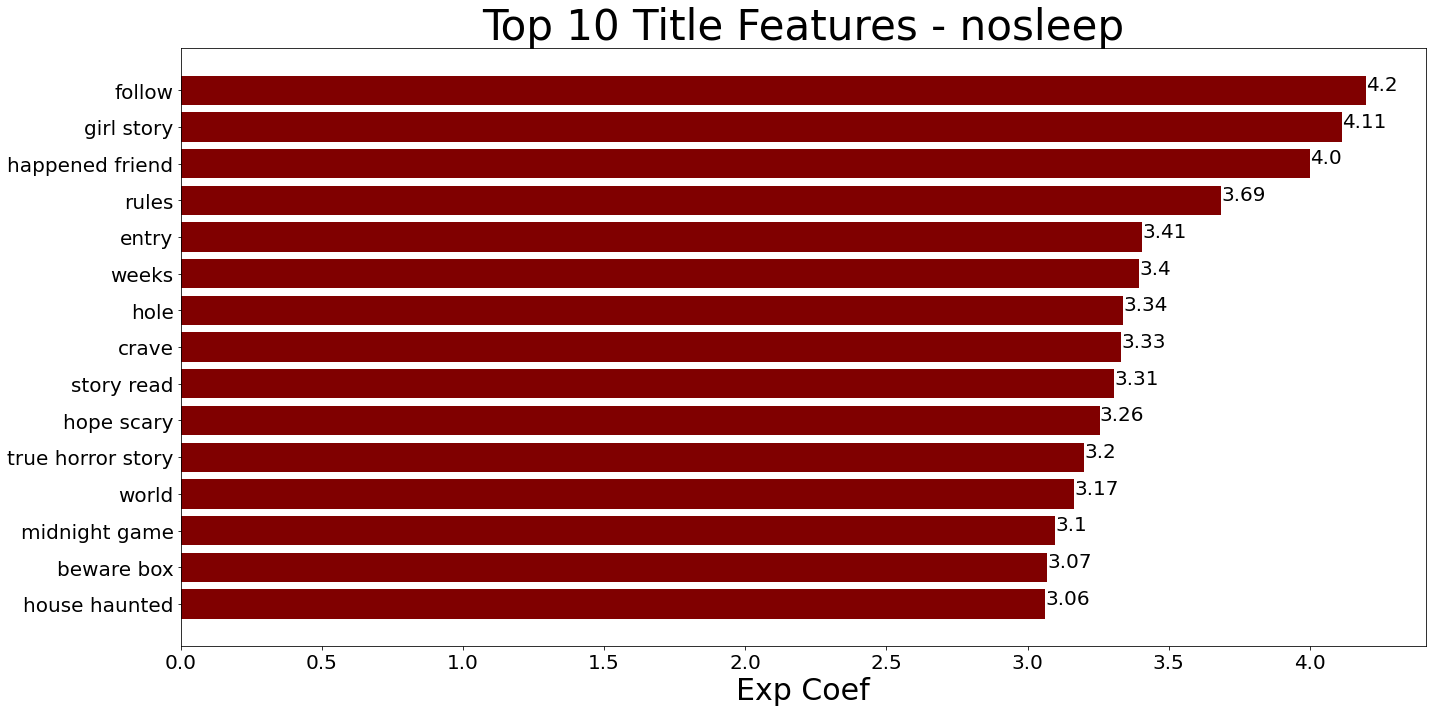

In [26]:
weights = coef_df['exp_coef'].head(15).sort_values()
labels = weights.index

plt.figure(figsize=(20,10))
plt.barh(labels, weights, color = 'maroon')
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.xlabel('Exp Coef', fontsize=30)
plt.title(f'Top 10 Title Features - nosleep', fontsize=42)
plt.tight_layout()

for index, value in enumerate(weights):
    plt.text(value, index, str(round(value,2)), fontsize = 20)


plt.savefig('../assets/nosleep_coef', bbox_inches='tight', dpi = 235);

## Coefficient Interpretation of top feature:
- **As there is a one word increase in our word 'follow', a reddit post is 4.2 times as likely to be from the nosleep subreddit**

## Mutinomial Bayes Model

In [27]:
X = df['clean_title']
y = df['subreddit']

In [28]:
# Create train_test_split.
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                   random_state = 42,
                                                   stratify = y)

In [29]:
tfidf_vect = TfidfVectorizer(max_df = 0.75, ngram_range = (1,2))                             

X_train_tvec = tfidf_vect.fit_transform(X_train)
X_test_tvec = tfidf_vect.transform(X_test)

In [30]:
multinom_bayes = MultinomialNB()
multinom_bayes.fit(X_train_tvec, y_train)
predictions = multinom_bayes.predict(X_test_tvec)

In [31]:
# Accuracy scores
print ('TFIDFVectorized Multinomial Bayes Model:')
print(f'Training Accuracy Score: {round(multinom_bayes.score(X_train_tvec, y_train) * 100, 2)}%.')
print(f'Testing Accuracy Score: {round(multinom_bayes.score(X_test_tvec, y_test) * 100, 2)}%.')

TFIDFVectorized Multinomial Bayes Model:
Training Accuracy Score: 91.04%.
Testing Accuracy Score: 71.28%.
